In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sys import path
path.append('..')
from statistical_clear_sky.algorithm.iterative_fitting import IterativeFitting
from statistical_clear_sky.solver_type import SolverType
#from statistical_clear_sky.utilities.data_conversion import make_time_series
from statistical_clear_sky.utilities.filters import lowpass_2d
#from statistical_clear_sky.algorithm.utilities.time_shifts import fix_time_shifts
from solardatatools import make_time_series, standardize_time_axis, make_2d, plot_2d, fix_time_shifts
import s3fs
import pandas as pd
import numpy as np
from numpy.fft import fft2, fftshift
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
PLOT_ARGS = {
    'linewidth': 1,
    'figsize': (12,8)
}
TZ_LOOKUP = {
    'America/Anchorage': 9,
    'America/Chicago': 6,
    'America/Denver': 7,
    'America/Los_Angeles': 8,
    'America/New_York': 5,
    'America/Phoenix': 7,
    'Pacific/Honolulu': 10
}
from datetime import datetime
from glob import glob

In [3]:
def load_sys(n=None, id_num=None, local=True):
    if local:
        base = '../data/PVO/'
    if not local:
        base = 's3://pvinsight.nrel/PVO/'
    meta = pd.read_csv('../data/PVO/sys_meta.csv')
    if id_num is None:
        id_num = meta['ID'][n]
    else:
        n = meta[meta['ID'] == id_num].index[0]
    df = pd.read_csv(base+'PVOutput/{}.csv'.format(id_num), index_col=0,
                      parse_dates=[0], usecols=[1, 3])
    #tz = meta['TimeZone'][n]
    #df.index = df.index.tz_localize(tz).tz_convert('Etc/GMT+{}'.format(TZ_LOOKUP[tz]))   # fix daylight savings
    #start = df.index[0]
    #end = df.index[-1]
    #time_index = pd.date_range(start=start, end=end, freq='5min')
    #df = df.reindex(index=time_index, fill_value=0)
    print(n, id_num)
    return df

In [4]:
fns = glob('../data/PVO/PVOutput/*')
fns.sort()
len(fns)

133

- `1533`: full winter shade
- 

In [5]:
def int_from_fn(index):
    return int(fns[index].split('/')[-1].split('.')[0])

In [6]:
df = load_sys(id_num=8008, local=True)

72 8008


In [9]:
power_signals_d = fix_time_shifts(make_2d(standardize_time_axis(df), key='Power(W)'), c1=2.)
p = power_signals_d.ravel(order='F')

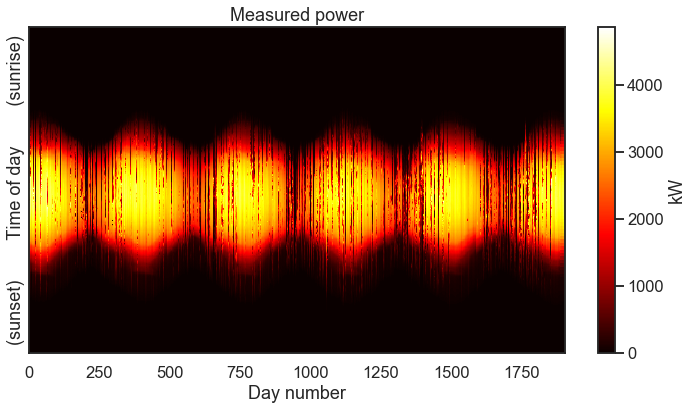

In [10]:
plot_2d(power_signals_d);

In [9]:
scsf = IterativeFitting(power_signals_d, rank_k=6, solver_type=SolverType.mosek)

obtaining weights


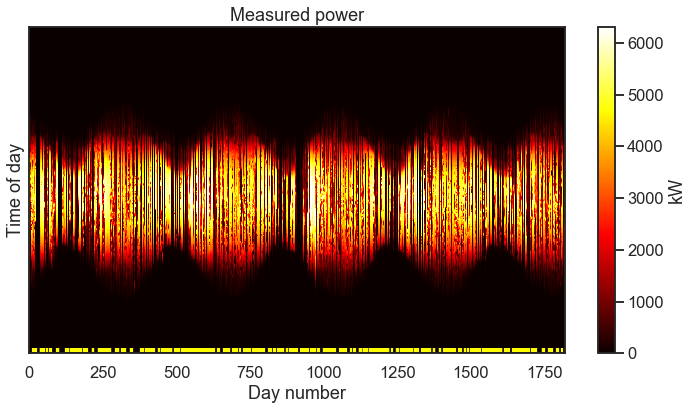

In [10]:
_ = scsf.plot_power_signals_d(show_days=True)

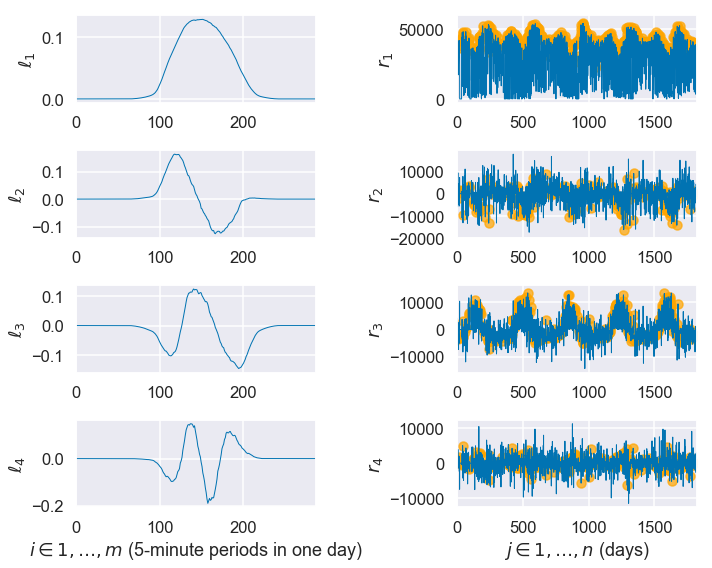

In [11]:
_ = scsf.plot_singular_vectors(show_days=True)

In [12]:
import cvxpy as cvx
try:
    scsf.execute(mu_l=5e2, mu_r=1e3, tau=0.85, max_iteration=10,
                              exit_criterion_epsilon=5e-3, 
                              max_degradation=None, min_degradation=None)
except cvx.SolverError:
    print('solver failed!')

obtaining initial value of component r0
obtaining weights
starting at 1792481310.271 [3947204.09490869, 94.8291366894512, 1435021984.8742976, 353512026.47237736]
Miminizing right R matrix
Miminizing left L matrix
iteration 1: 4097750.739 [3.75366909e+06 9.72607000e+02 3.43109028e+05 1.50000000e-02]
Miminizing right R matrix
Miminizing left L matrix
iteration 2: 3458679.989 [3.13451118e+06 7.20798000e+02 3.23447973e+05 3.50000000e-02]
Miminizing right R matrix
Miminizing left L matrix
iteration 3: 3271778.086 [2.92415118e+06 6.52150000e+02 3.46974699e+05 5.60000000e-02]
Miminizing right R matrix
Miminizing left L matrix
iteration 4: 3173140.069 [2.80689923e+06 6.17909000e+02 3.65622920e+05 1.10000000e-02]
Miminizing right R matrix
Miminizing left L matrix
iteration 5: 3127648.217 [2.75590966e+06 6.00569000e+02 3.71137981e+05 9.00000000e-03]
Miminizing right R matrix
Miminizing left L matrix
iteration 6: 3113454.831 [2.74189834e+06 6.25050000e+02 3.70931431e+05 1.00000000e-02]
Minimizati

In [13]:
clearsky = scsf.clear_sky_signals()
m = clearsky != 0
residuals = np.divide(clearsky[m] - scsf.power_signals_d[m], clearsky[m])
print(np.linalg.norm(residuals))

19532808.937027525


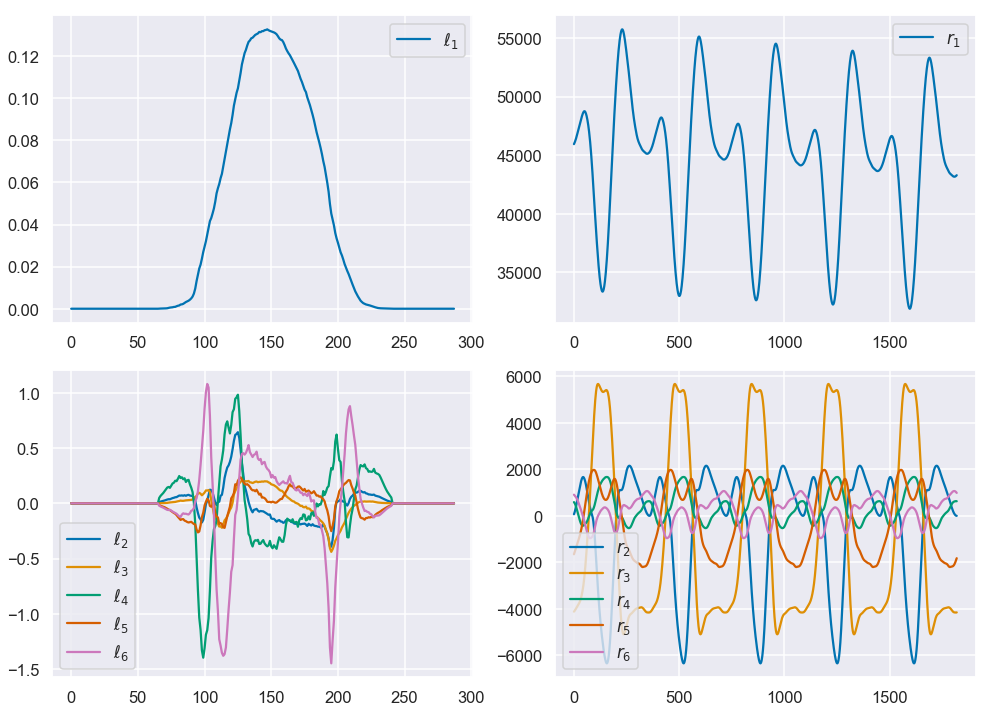

In [14]:
_ = scsf.plot_lr()

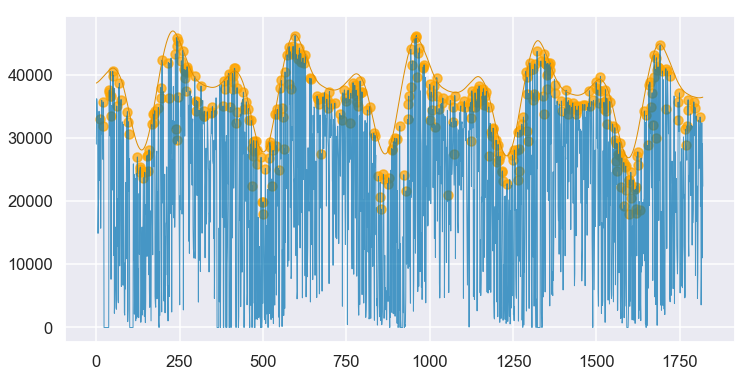

In [15]:
_ = scsf.plot_energy(show_clear=True)

Here is the estimated degradation rate (year on year energy-yield) for the system:

In [16]:
scsf.beta_value

array(-0.0110409)

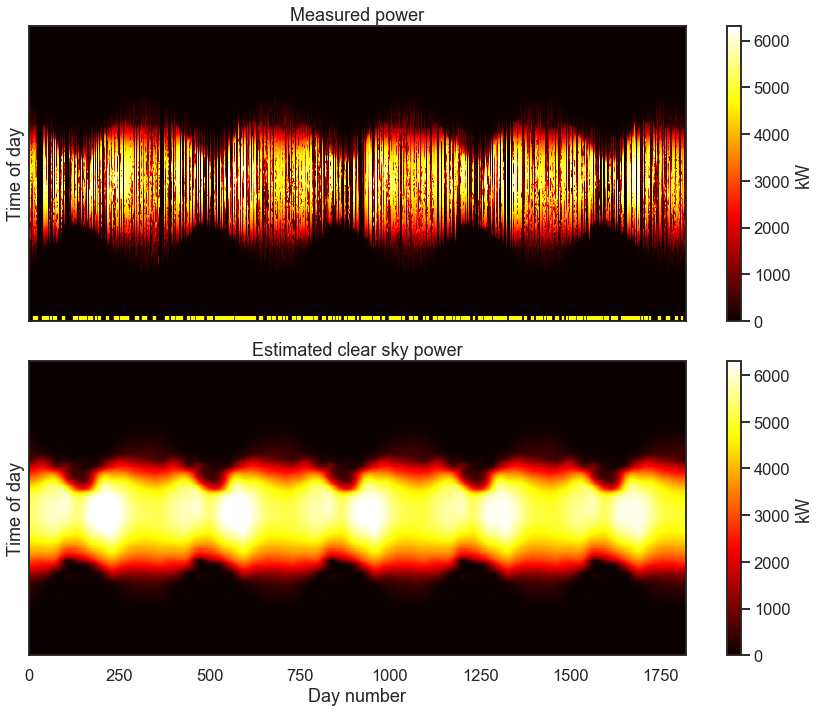

In [17]:
_ = scsf.plot_measured_clear(figsize=(12, 10), show_days=True)

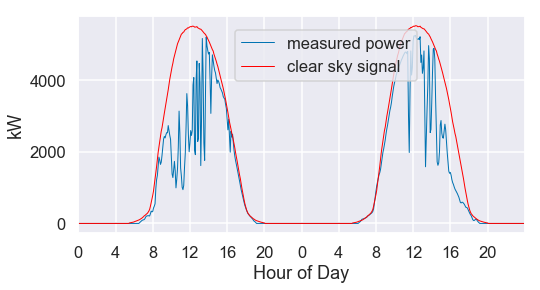

In [18]:
scsf.ts_plot(start_day=387);

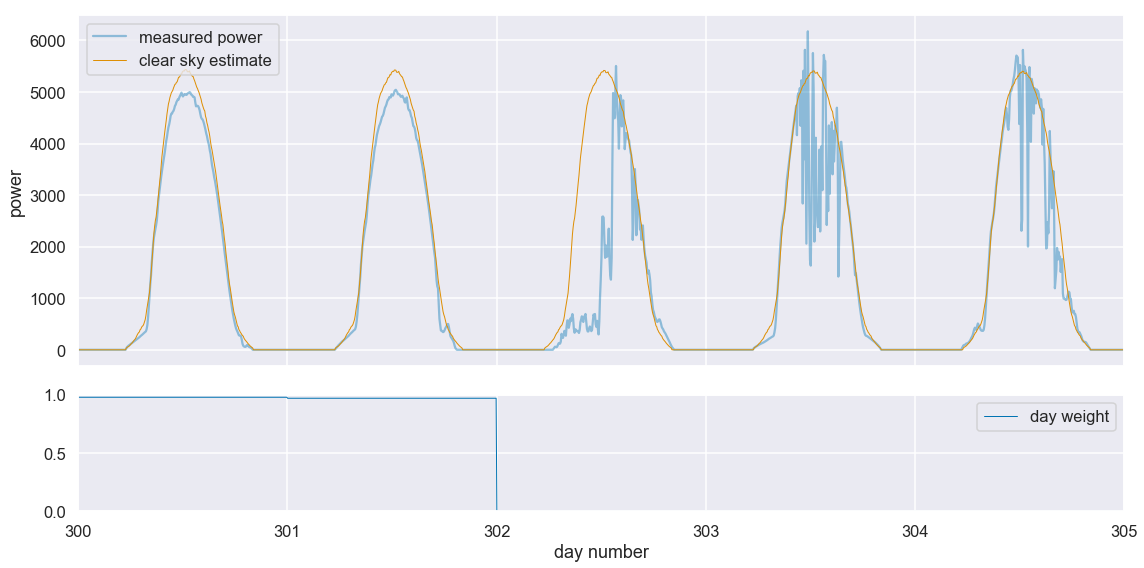

In [19]:
scsf.ts_plot_with_weights(start_day=300);

In [20]:
scsf2 = IterativeFitting(power_signals_d, rank_k=6, solver_type=SolverType.mosek)

In [21]:
import cvxpy as cvx
try:
    scsf2.execute(mu_l=5e2, mu_r=1e3, tau=0.85, max_iteration=10,
                              exit_criterion_epsilon=5e-3, 
                              is_degradation_calculated=False)
except cvx.SolverError:
    print('solver failed!')

obtaining initial value of component r0
obtaining weights
starting at 1792481310.271 [3947204.09490869, 94.8291366894512, 1435021984.8742976, 353512026.47237736]
Miminizing right R matrix
Miminizing left L matrix
iteration 1: 4182538.524 [3.83300720e+06 7.96148000e+02 3.48735167e+05 1.20000000e-02]
Miminizing right R matrix
Miminizing left L matrix
iteration 2: 3520904.476 [3.19784889e+06 6.13561000e+02 3.22442022e+05 6.00000000e-03]
Miminizing right R matrix
Miminizing left L matrix
iteration 3: 3331526.268 [2.97951034e+06 5.44926000e+02 3.51470994e+05 1.00000000e-02]
Miminizing right R matrix
Miminizing left L matrix
iteration 4: 3250336.441 [2.87912993e+06 5.82424000e+02 3.70624072e+05 1.70000000e-02]
Miminizing right R matrix
Miminizing left L matrix
iteration 5: 3231193.272 [2.85883211e+06 5.49084000e+02 3.71812065e+05 1.00000000e-02]
Miminizing right R matrix
Miminizing left L matrix
iteration 6: 3222452.315 [2.85053268e+06 5.83818000e+02 3.71335797e+05 2.00000000e-02]
Minimizati

In [31]:
scsf.calculate_objective_with_result(sum_components=False)

[2741898.3396000694,
 625.0502009481534,
 370931.4308877656,
 0.010346947614282986]

In [30]:
scsf2.calculate_objective_with_result(sum_components=False)

[2850532.680103721, 583.8184312614773, 371335.7965479518, 0.01970585556414708]

In [23]:
clearsky = scsf2.clear_sky_signals()
m = clearsky != 0
residuals = np.divide(clearsky[m] - scsf2.power_signals_d[m], clearsky[m])
print(np.linalg.norm(residuals))

1038381.2885469877


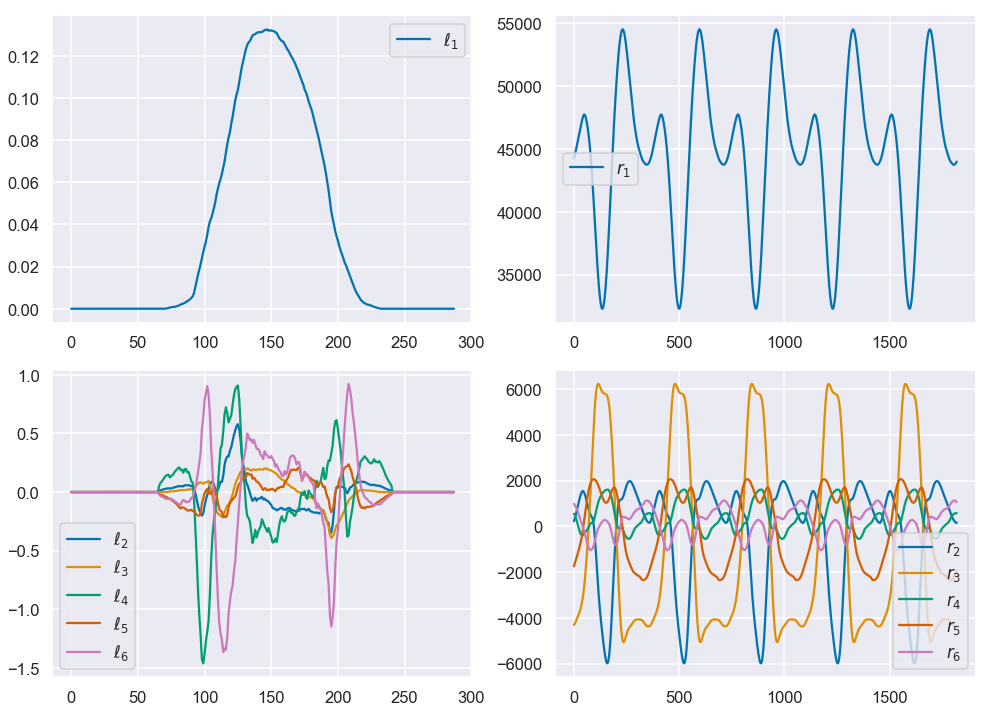

In [25]:
_ = scsf2.plot_lr()

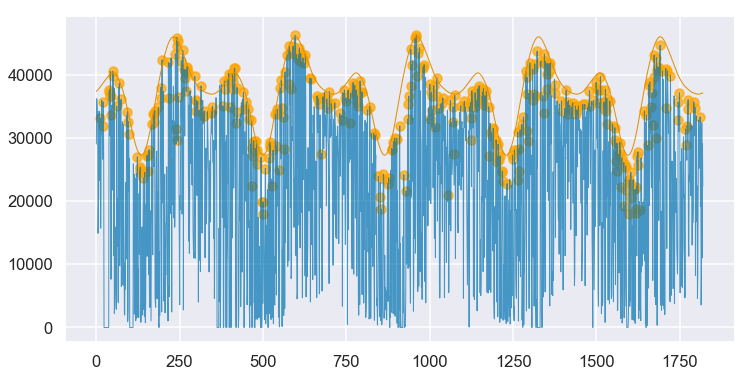

In [26]:
_ = scsf2.plot_energy(show_clear=True)

Here is the estimated degradation rate (year on year energy-yield) for the system:

In [32]:
scsf2.beta_value

0.0

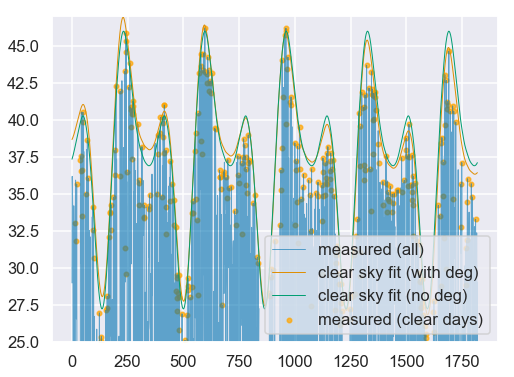

In [63]:
plt.figure(figsize=(8,6))
plt.plot(np.sum(scsf.power_signals_d, axis=0) * 24 / scsf._power_signals_d.shape[0] / 1000,
         linewidth=1, alpha=0.6, label='measured (all)')
plt.plot(np.sum(scsf.clear_sky_signals(), axis=0) * 24 / scsf._power_signals_d.shape[0] / 1000,
         linewidth=1, label='clear sky fit (with deg)')
plt.plot(np.sum(scsf2.clear_sky_signals(), axis=0) * 24 / scsf2._power_signals_d.shape[0] / 1000,
         linewidth=1, label='clear sky fit (no deg)')
use_day = scsf._obtain_weights_for_plotting() > 1e-1
days = np.arange(scsf._power_signals_d.shape[1])
plt.scatter(days[use_day], np.sum(scsf._power_signals_d,
    axis=0)[use_day] * 24 / scsf._power_signals_d.shape[0] / 1000,
    color='orange', alpha=0.7, marker='.', label='measured (clear days)')
plt.ylim(25, 47)
#plt.xlim(1000, 1800)
plt.legend()
plt.show()

In [ ]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(8,8), sharex=True)
    r = iterative_fitting.clear_sky_signals() - iterative_fitting.power_signals_d
    val = np.max([np.abs(np.min(r)), np.abs(np.max(r))])
    foo = ax.imshow(r, cmap='RdBu', interpolation='none', aspect='auto', vmin=-val, vmax=val)
    #plt.colorbar(label='kW')
    ax.set_title('Residual power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')
    plt.tight_layout()

In [ ]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(8,8), sharex=True)
    r = iterative_fitting.clear_sky_signals() - iterative_fitting.power_signals_d
    val = np.max([np.abs(np.min(r)), np.abs(np.max(r))])
    foo = ax.imshow(lowpass_2d(r, r=15), cmap='RdBu', interpolation='none', aspect='auto', vmin=-val, vmax=val)
    #plt.colorbar(label='kW')
    ax.set_title('Residual power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')
    plt.tight_layout()

In [ ]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
    foo = ax.imshow(lowpass_2d(power_signals_d, r=15), cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax.set_title('Measured power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.sum(power_signals_d, axis=0), linewidth=1)
plt.plot(np.sum(lowpass_2d(power_signals_d, r=15), axis=0), linewidth=3)